<h1> How I learned to stop worrying and love uncertainty </h1>

An introductory workshop on quantifying uncertainty in building simulation.

<b>author</b>: Parag Rastogi; <b>venue</b>: CEPT University, Ahmedabad; <b>date</b>: 05-06 January, 2019.

Run each module one-by-one by either using the <kbd>run cell</kbd> button above or pressing <kbd>Ctrl + Enter</kbd> when a cell is selected. Modules like this one are `Markdown` modules, which is a kind of text-encoding language. These will not produce an output - instead you will see formatted text in the cell when you run one.


<h2>Types of uncertainty and exercises</h2>

The uncertainty in inputs can be separated into two types:

<ol>
    <li> Epistemic - lack of knowledge
    <li> Aleatory - inherent randomness
</ol>

In general, epistemic uncertainty can be reduced with better knowledge but aleatory cannot. Sometimes natural phenomena that appear aleatory, as in, inherently random, may not be so; it could just be that our lack of knowledge about these phenomena makes them seem random. The climate is a good example of this.

<strong>Exercise: Write down two examples of epistemic and aleatory uncertainty related to building simulation, performance, or design.</strong>

============================================================================================================

In this exercise we will use a regression model (black-box model) to estimate the response of a building. We will do an exercise related to epistemic uncertainty and one related to aleatory. The rest of the workshop is structured as follows:

<ol>
    <li> Loading python modules and weather files.
    <li> Black-box models.
    <li> Epistemic uncertainty with black-box models.
    <li> Aleatory uncertainty with black-box models.
</ol>

In [1]:
# Import various standard modules.
# os gives you access to various functions related to the file system. 
import os
# pickle is used to compress and store data. 
import pickle
# pandas is a great package for manipulating data.
import pandas as pd
# numpy gives you various maths functions.
import numpy as np

# There's a good reason this package is used to make copies of variables.
import copy

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

# We will use a scaler to ensure that all the inputs are of roughly the same order of magnitude. 
# This does not make much of a difference when you fit regression models like we did above,
# since the magnitudes of the coefficients match those of the features to produce the correct
# magnitude of output. 
# However, we need it here to demonstrate sensitivity and uncertainty.
from sklearn.preprocessing import StandardScaler

# Plotting modules.
import matplotlib.pyplot as plt
# import seaborn as sns

# Get inline graphs .
%matplotlib inline

# Only useful for debugging, when you 
# need to reload external modules.
from importlib import reload

# Enable xkcd mode - if you're a nerd.
# plt.xkcd()

# Import a custom read-write function for weather files.
import wfileio as wf

# import small helpers I've written.
from petites import circ_rolling_mean
from petites import smoother

# Import an awesome colour palette. Call it colours.
import default_colours as colours

# Set the random seed to a specific value so
# the experiment is repeatable.
# See  https://en.wikipedia.org/wiki/Random_seed  for more information on what this means.
# For why I chose 42, read The Hitchhiker's Guide to the Galaxy.
np.random.seed(42)

<h2> Black Box Models </h2>

A black-box model is any model (mathematical relationship) that can only be viewed in terms of its inputs and outputs. That is, we cannot "see" the inner workings or relationships that result in certain inputs giving certain outputs. It can be used to represent a physical system if sufficient data is available to characterise the relationship between the inputs and outputs of that system. In building simulation, for example, a black-box model could relate outside temperature to heating demand without any indication of <i>how</i> that demand is generated physically, i.e., without solving the equations of heat transfer.  

For this workshop, we will use <kbd>scikit-learn</kbd> (use the alias <kbd>sklearn</kbd> when installing with <kbd>pip</kbd> or <kbd>conda</kbd>), a library in python, to fit models to data obtained from energy plus simulations.  

<h2>Exercises</h2>

We will do two exercises, each linked to a different type of uncertainty: 

<ol>
<li> Epistemic uncertainty: fixed inputs, random coefficients. 
<li> Aleatory uncertainty: random inputs, fixed coefficients.
</ol>

In [2]:
# Load data from energyplus simulations.

path_data = '../sim_data/SummaryTable_BaseSimulation.csv'

df_eplus = pd.read_csv(path_data)

# Drop rows that contain infinity, negative infinity, NaN values.
df_eplus = df_eplus.dropna(how='any', axis='index')

<h2> Uncertainty quantification - demonstration </h2>

Now that we have demonstrated regression models, let's use them to explore the quantification of uncertainty. To do that, let's pick one building and climate from the dataset. I will select the large office building and Geneva,
since I have the most simulations from this combination.

We will pretend that the data we have at hand represents a real design problem. 

Remember that, in our exercises, the coefficients of the regression equation represent the magnitude of effect each input or property has on the output. The regression inputs are varying values of building properties (e.g., internal heat gain) and boundary conditions (e.g., weather). Once the building's properties are fixed, variation in the boundary conditions creates variation in energy and other outputs of interest (like indoor temperature). During design, however, it makes sense to test each building property over many boundary conditions to ensure that performance is as expected.

In [3]:
# Select the relevant rows using two logical statements connected with an AND statement.
gen_office = df_eplus.loc[
    np.logical_and(df_eplus.loc[:, 'idfname']=='D101C00', df_eplus.loc[:, 'wthrfolder']=='GEN'), :]

# Let's see if the selection worked.
# These statements should give you only one output each:
# 'GEN' for Geneva and...
print(gen_office.loc[:, 'wthrfolder'].unique())
# D101C00 for the building name (idfname).
print(gen_office.loc[:, 'idfname'].unique())

# Resulting size.
print('Size: ', gen_office.shape)

['GEN']
['D101C00']
Size:  (652, 45)


In [4]:
# Work with a reduced set of independent variables (inputs, x).
selected_xvars = ['hdd', 'cdd', 'sumihg', 'suminfloss', 'suminfgain']
# Sums are in GWh. DD are in count.

# Select only these columns as training data.
x_train = df_eplus.loc[:, selected_xvars]
# No test samples in this case.
y_train = df_eplus.loc[:, ['heatnorm', 'coolnorm']]

print(x_train.describe())

                 hdd           cdd        sumihg    suminfloss    suminfgain
count   88242.000000  88242.000000  88242.000000  88242.000000  88242.000000
mean    53391.356429  18273.986647      1.132923     -0.211768      0.011458
std     20419.626463   9047.317223      1.462164      0.244252      0.027552
min      9617.200000    424.800000      0.044526     -2.325690      0.000000
25%     41588.200000  11824.100000      0.230182     -0.277302      0.001062
50%     50393.500000  16829.400000      0.569135     -0.136204      0.003317
75%     62422.700000  24008.700000      1.015783     -0.051681      0.009469
max    159906.300000  54722.600000      5.236709     -0.000159      0.427041


In [5]:
# Same plotting function as before.

# Define min and max to set pretty axis limits.
axmin = dict(heat=y_train['heatnorm'].min().round(-1),
             cool=y_train['coolnorm'].min().round(-1))
axmax = dict(heat=y_train['heatnorm'].max().round(-1),
             cool=y_train['coolnorm'].max().round(-1))
bins = dict(heat=np.linspace(-100, 100, num=25),
            cool=np.linspace(-100, 100, num=25))

print(axmin)
print(axmax)
# print(bins)

def plot_predictions(y_test, y_pred, y_train):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12)) 
    ax = axes.flatten()
    fig.tight_layout(pad=3, w_pad=3, h_pad=5)

    ax[0].plot(y_test['heatnorm'], y_pred['heatnorm'], color=colours.hotpink, marker='.', linewidth=0)
    ax[0].plot(y_test['heatnorm'], np.repeat(y_train['heatnorm'].mean(), y_test.shape[0]),
               color=colours.blackest, linewidth=2)
    ax[0].set_xlim(axmin['heat'], axmax['heat'])
    ax[0].set_ylim(axmin['heat'], axmax['heat'])
    ax[0].set_title('Heating')
    ax[0].set_xlabel('Simulated (E+) [kWh/$m^2$]')
    ax[0].set_ylabel('Predicted (regression) [kWh/$m^2$]')
    ax[0].legend({'Mean', 'Model'})

    ax[1].plot(y_test['coolnorm'], y_pred['coolnorm'], color=colours.blue, marker='.', linewidth=0)
    ax[1].plot(y_test['coolnorm'], np.repeat(y_train['coolnorm'].mean(), y_test.shape[0]),
               color=colours.blackest, linewidth=2)
    ax[1].set_xlim(axmin['cool'], axmax['cool'])
    ax[1].set_ylim(axmin['cool'], axmax['cool'])
    ax[1].set_title('Cooling')
    ax[1].set_xlabel('Simulated (E+) [kWh/$m^2$]')
    ax[1].set_ylabel('Predicted (regression) [kWh/$m^2$]')
    ax[1].legend({'Mean', 'Model'})
    
    ax[2].hist(y_test['heatnorm'] - y_pred['heatnorm'], bins=bins['heat'],
               density=False, color=colours.hotpink, alpha=0.5, align='left', rwidth=0.75)
    ax[2].set_title('Errors - Heating')
    ax[2].set_ylabel('Count')
    ax[2].set_xlabel('$\epsilon$ [kWh/$m^2$]')

    ax[3].hist(y_test['coolnorm'] - y_pred['coolnorm'], bins=bins['cool'],
               density=False, color=colours.blue, alpha=0.5, align='left', rwidth=0.75)
    ax[3].set_title('Errors - Cooling')
    ax[3].set_ylabel('Count')
    ax[3].set_xlabel('$\epsilon$ [kWh/$m^2$]')


{'heat': 0.0, 'cool': 0.0}
{'heat': 1650.0, 'cool': 350.0}


In [6]:
model_poly3_features = PolynomialFeatures(1)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
y_train_scaled = scaler_y.fit_transform(y_train)

x_train_trans = model_poly3_features.fit_transform(x_train_scaled)
model_poly3_regr = dict(heatnorm=LinearRegression(), coolnorm=LinearRegression())
model_poly3_regr['heatnorm'].fit(X=x_train_trans, y=y_train_scaled[:, 0])
model_poly3_regr['coolnorm'].fit(X=x_train_trans, y=y_train_scaled[:, 1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

<h2>Epistemic Uncertainty </h2>

<h3>Random building inputs, fixed boundary conditions</h3>


<h2>Epistemic Uncertainty </h2>

<h3>Random coefficients, fixed inputs</h3>

If we use random coefficients to specify the relationship between inputs and output, the resulting equation represents a situation where there is a lack of knowledge about the sensitivity of outputs to the inputs. That is to say, <i>if we don't know the relationships, then they appear random</i>.

In [17]:
# Epistemic

# Imagine we knew nothing about the infiltration gain, except that it could be between 0 and 3 GWh.
suminfgain_sample = np.linspace(0, 10, num=x_train.shape[0])

# scaler_x1 = StandardScaler()
# scaler_y1 = StandardScaler()

# Now let us see how our "design performance" would be affected by not knowing the infiltration loss precisely.

# Copy the original data.
x_test1 = copy.copy(x_train)
# Change the suminfgain column.
x_test1.loc[:, 'suminfgain'] = suminfgain_sample

x_test1_scaled = scaler_x.fit_transform(x_test1)
x_test_trans = model_poly3_features.fit_transform(x_test1_scaled)

y_pred = np.NaN*np.ones([y_train.shape[0], 2]) 

# for idx, x in enumerate(x_test1_scaled):
y_pred[:, 0] = model_poly3_regr['heatnorm'].predict(x_test_trans)
y_pred[:, 1] = model_poly3_regr['coolnorm'].predict(x_test_trans)

# Inverse the transformation and put the resulting predictions into a dataframe for plotting.
y_pred = pd.DataFrame(scaler_y.inverse_transform(y_pred), columns=['heatnorm', 'coolnorm'])

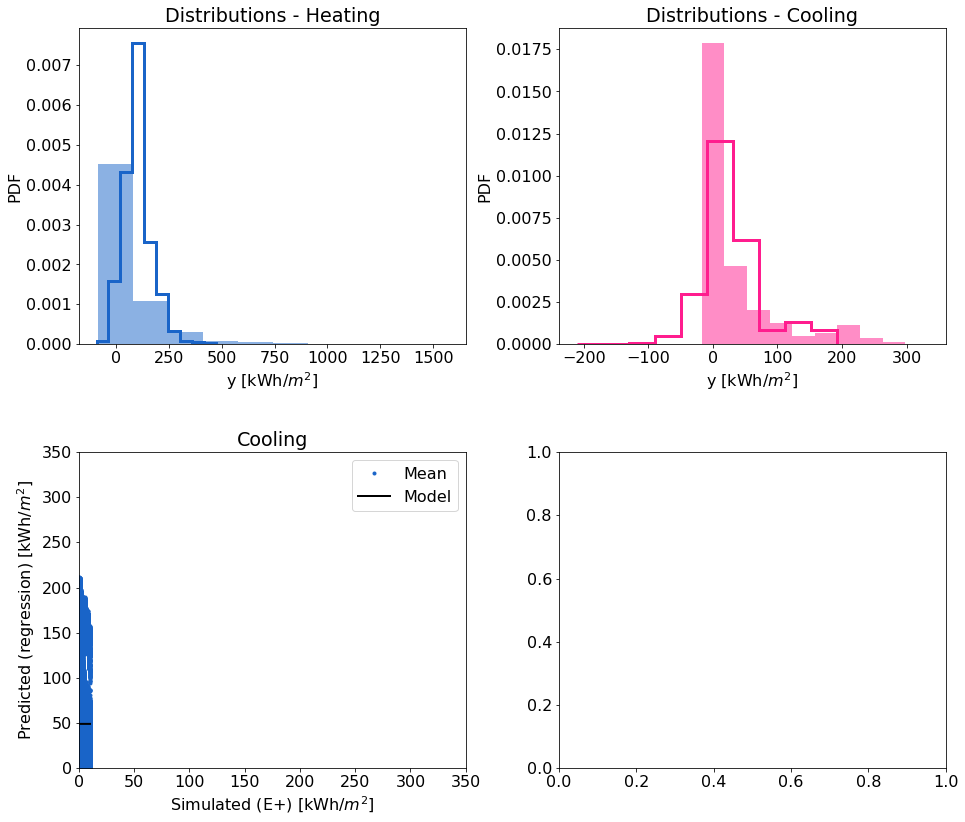

In [24]:
# Set default font properties.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=3, h_pad=5)

ax[0].hist(y_train['heatnorm'], density=True, color=colours.blue, alpha=0.5,
           align='left')
ax[0].hist(y_pred['heatnorm'], density=True, color=colours.blue, alpha=1,
           histtype='step', align='left', linewidth=3)
ax[0].set_title('Distributions - Heating')
ax[0].set_ylabel('PDF')
ax[0].set_xlabel('y [kWh/$m^2$]')

ax[1].hist(y_train['coolnorm'], density=True, color=colours.hotpink, alpha=0.5,
           align='left')
ax[1].hist(y_pred['coolnorm'], density=True, color=colours.hotpink, alpha=1,
           histtype='step', align='left', linewidth=3)
ax[1].set_title('Distributions - Cooling')
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('y [kWh/$m^2$]')


ax[2].plot(x_test1.loc[:,'suminfgain'], y_pred['coolnorm'], color=colours.blue, marker='.', linewidth=0)
ax[2].plot(x_test1.loc[:,'suminfgain'], np.repeat(y_train['coolnorm'].mean(), y_train.shape[0]),
           color=colours.blackest, linewidth=2)
ax[2].set_xlim(axmin['cool'], axmax['cool'])
ax[2].set_ylim(axmin['cool'], axmax['cool'])
ax[2].set_title('Cooling')
ax[2].set_xlabel('Simulated (E+) [kWh/$m^2$]')
ax[2].set_ylabel('Predicted (regression) [kWh/$m^2$]')
ax[2].legend({'Mean', 'Model'})

<h2> Bibliography </h2>

<ul>
<li>Rastogi, Parag. 2016. “On the Sensitivity of Buildings to Climate: The Interaction of Weather and Building Envelopes in Determining Future Building Energy Consumption.” PhD, Lausanne, Switzerland: Ecole polytechnique fédérale de Lausanne. EPFL Infoscience. https://infoscience.epfl.ch/record/220971?ln=en.
<li>Rastogi, Parag, and Marilyne Andersen. 2015. “Embedding Stochasticity in Building Simulation Through Synthetic Weather Files.” In Proceedings of BS 2015. Hyderabad, India. http://infoscience.epfl.ch/record/208743.
<li>———. 2016. “Incorporating Climate Change Predictions in the Analysis of Weather-Based Uncertainty.” In Proceedings of SimBuild 2016. Salt Lake City, UT, USA. http://infoscience.epfl.ch/record/208743.
<li>Rastogi, Parag, Mohammad Emtiyaz Khan, and Marilyne Andersen. 2017. “Gaussian-Process-Based Emulators for Building Performance Simulation.” In Proceedings of BS 2017. San Francisco, CA, USA: IBPSA.
<li>Iaccarino, Gianluca. 2008. “Quantification of Uncertainty in Flow Simulations Using Probabilistic Methods.” presented at the VKI Lecture Series, Stanford University, September. http://web.stanford.edu/group/uq/uq_youq.html.
<li>Macdonald, Iain. 2002. “Quantifying the Effects of Uncertainty in Building Simulation.” Doctoral, University of Strathclyde. https://www.strath.ac.uk/media/departments/mechanicalengineering/esru/research/phdmphilprojects/macdonald_thesis.pdf.

</ul>